'Algorithm‑level summary'

,Algorithm,Mean_TimeDuration,Mean_Rounds,Mean_TotalMessages,Mean_OKPercentage,Mean_CorruptedPercentage,Mean_LostPercentage
0,Broadcast,6.214109e+07,1.00,349.00,51.87,12.31,35.81
1,GossipPull,1.061553e+11,15.23,5963.76,36.45,43.53,20.01
2,GossipPush,1.653567e+11,15.39,2733.64,35.85,40.28,23.87
3,GossipPushPull,2.623824e+10,9.56,10105.63,39.86,38.38,21.77
4,Multicast,5.226528e+09,3.00,349.00,34.87,15.29,49.84
5,Singlecast,5.308545e+07,1.00,2.41,0.85,0.20,98.95


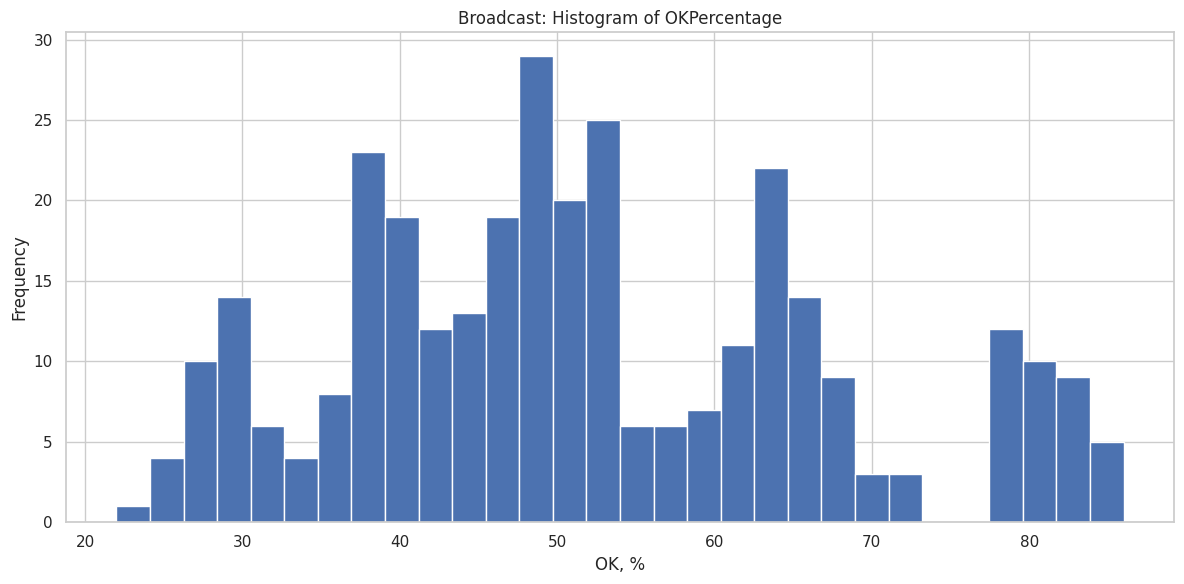

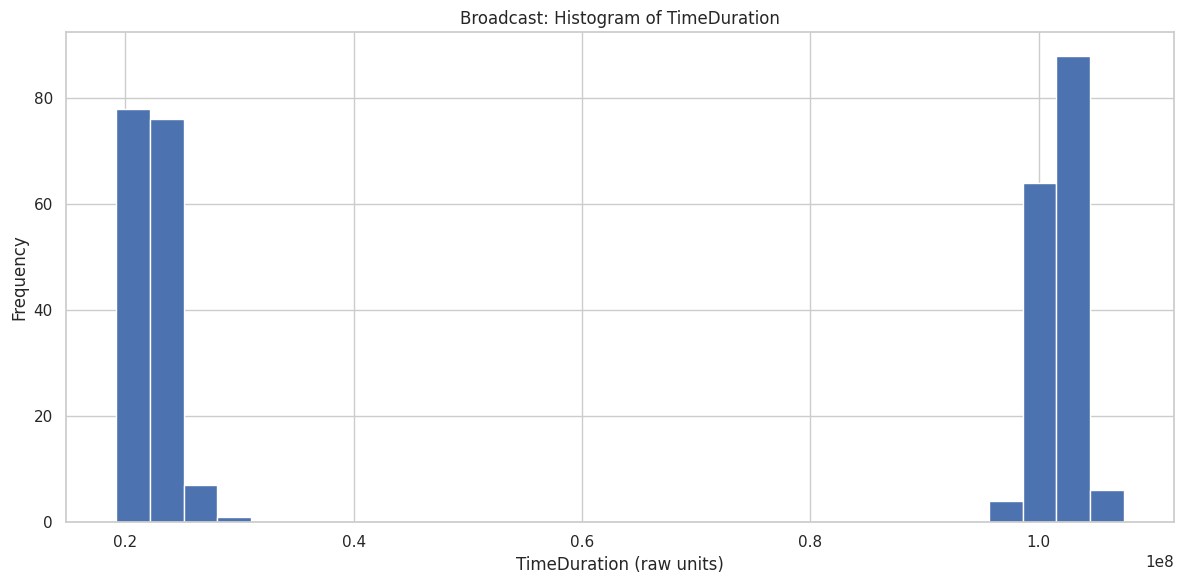

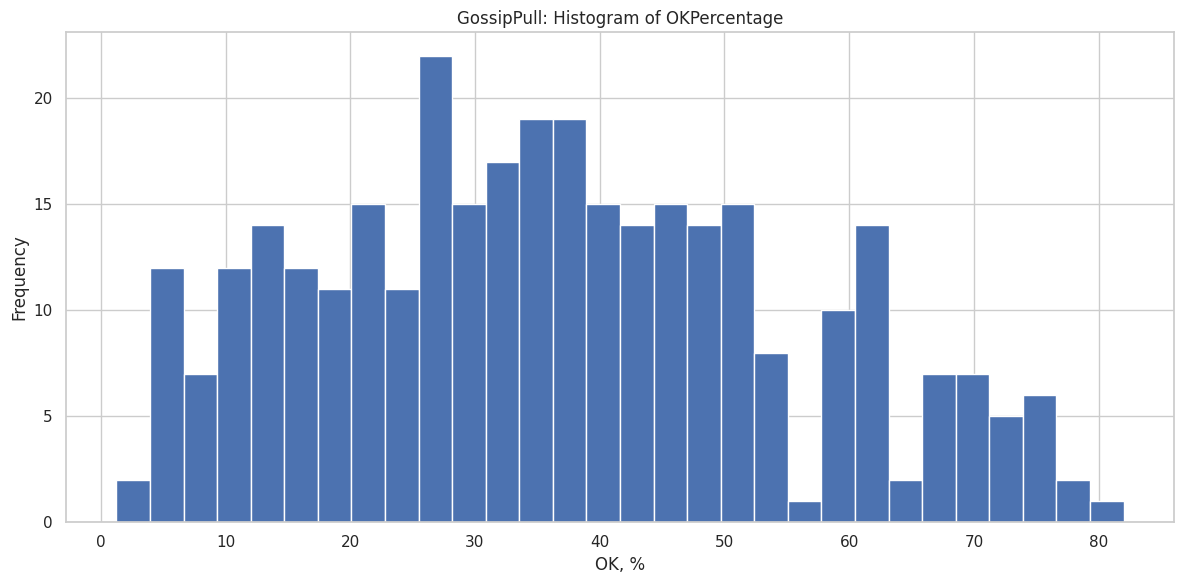

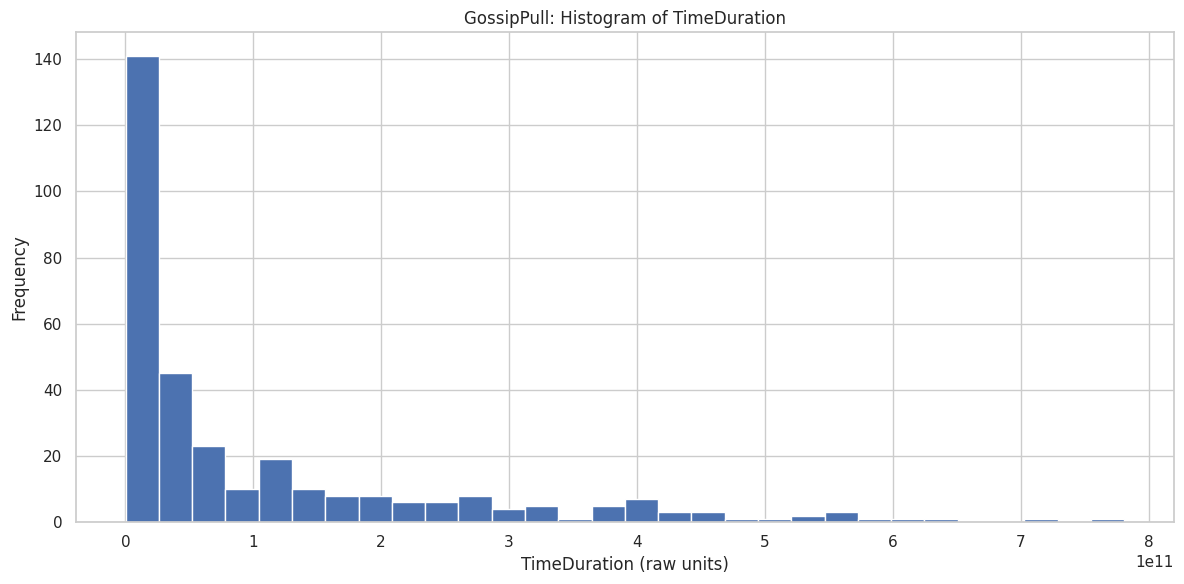

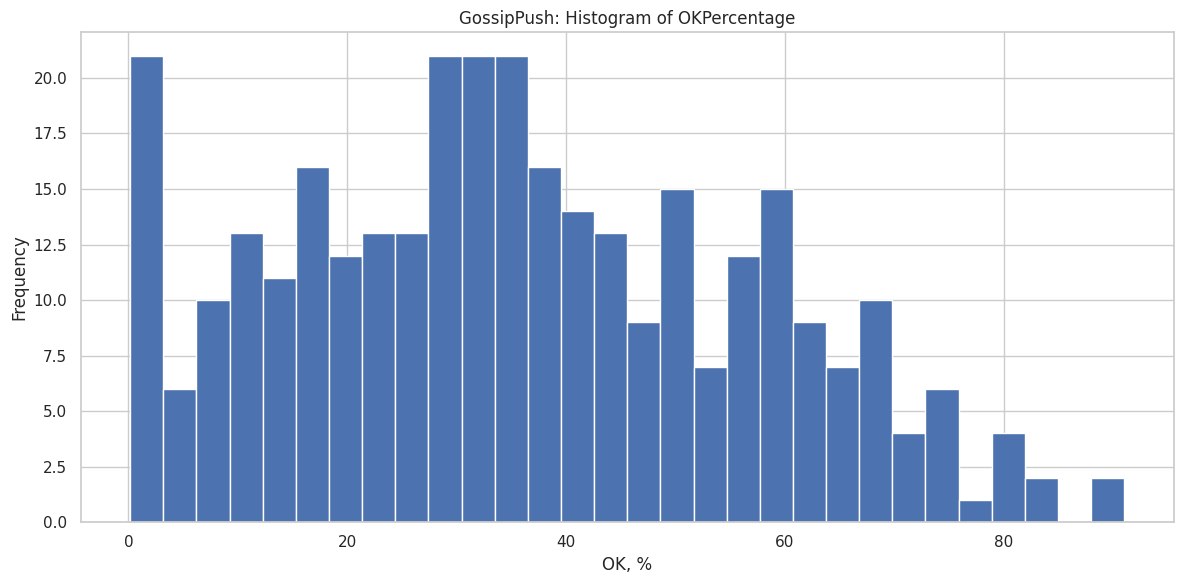

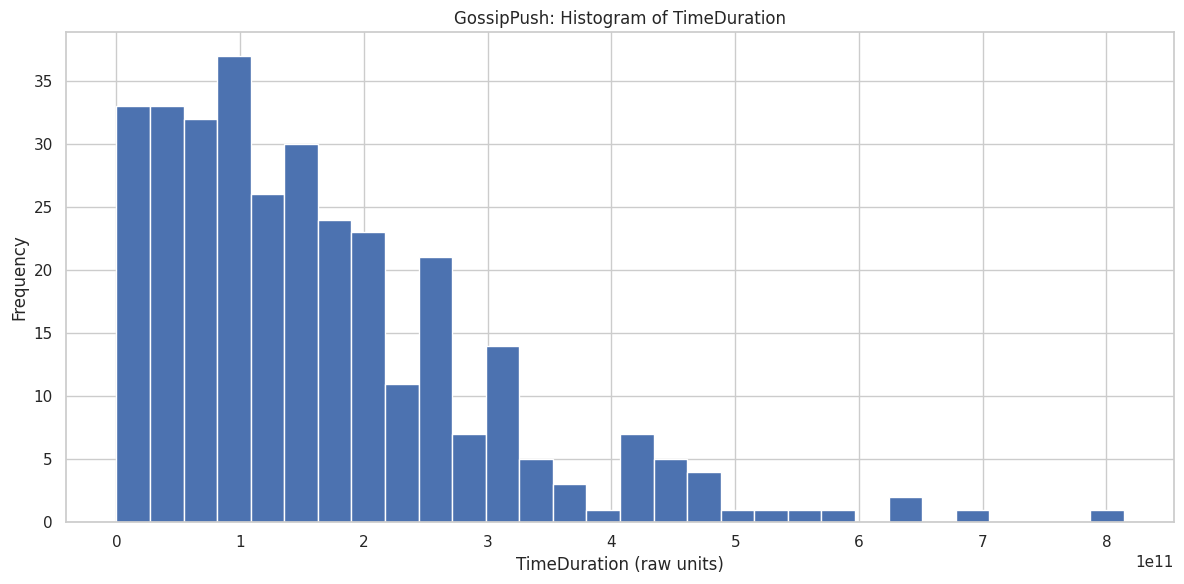

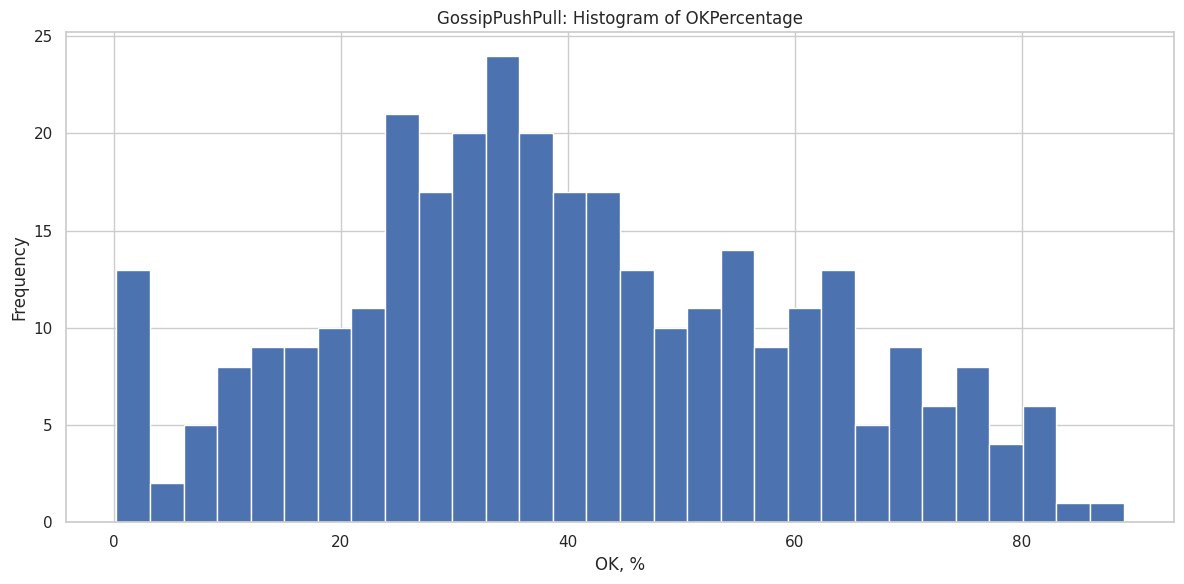

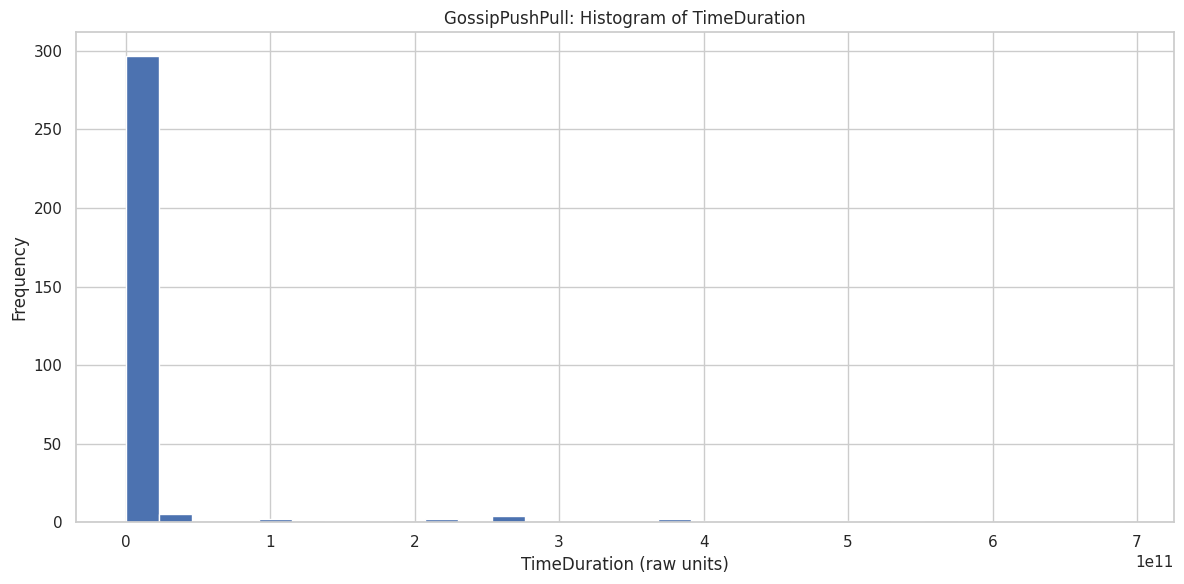

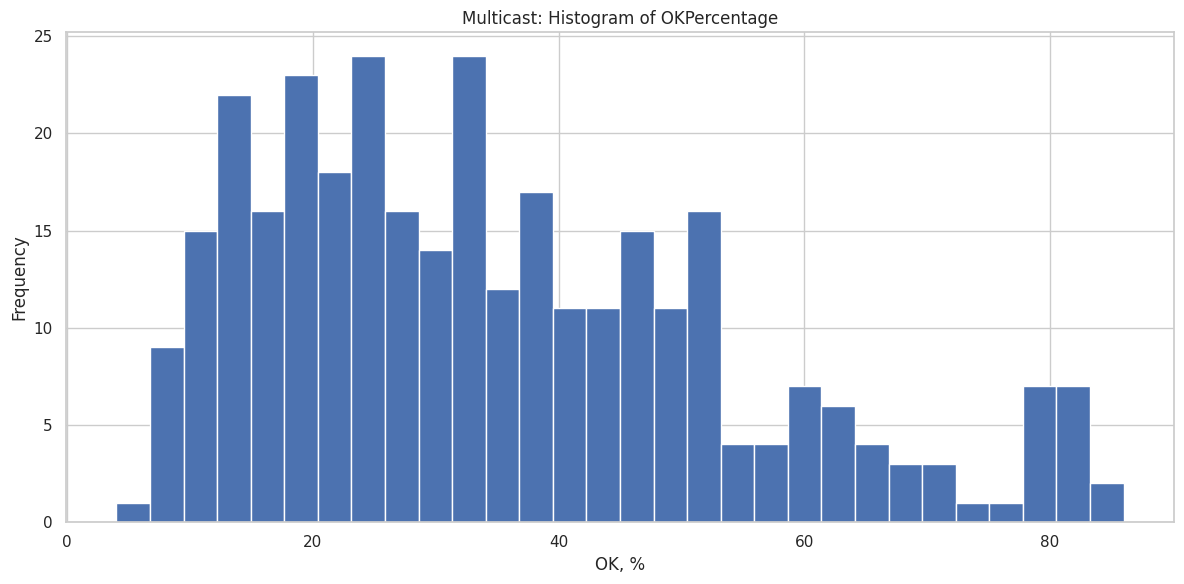

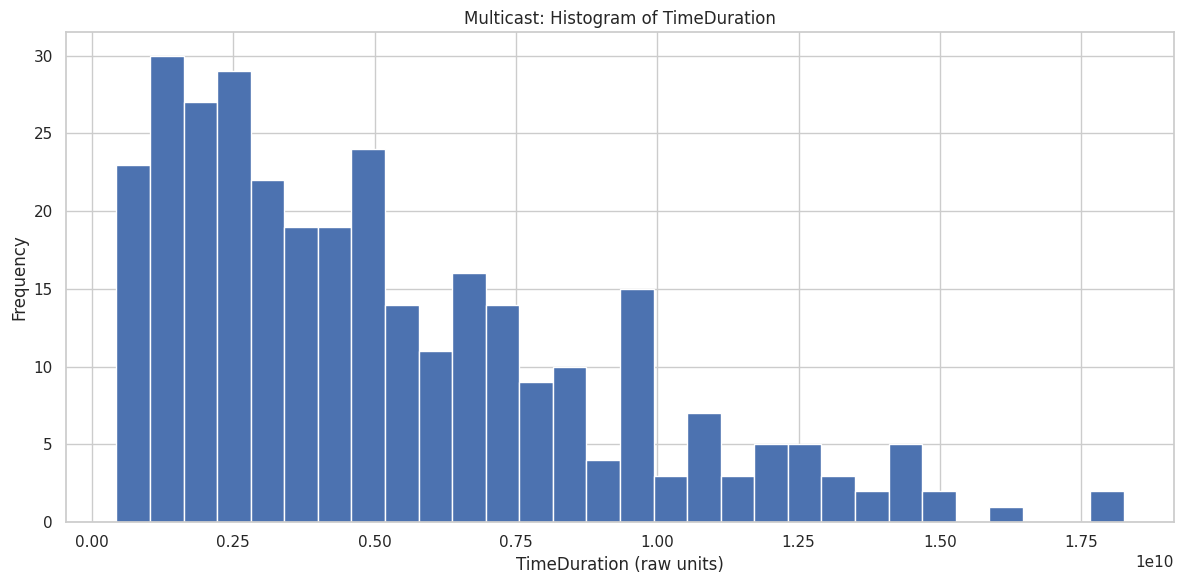

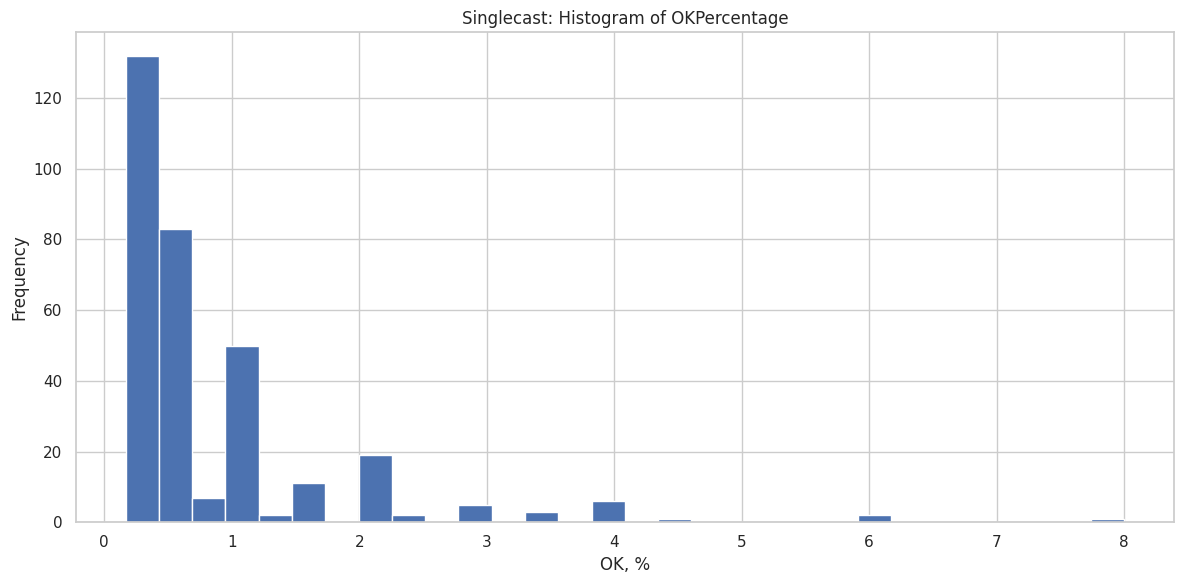

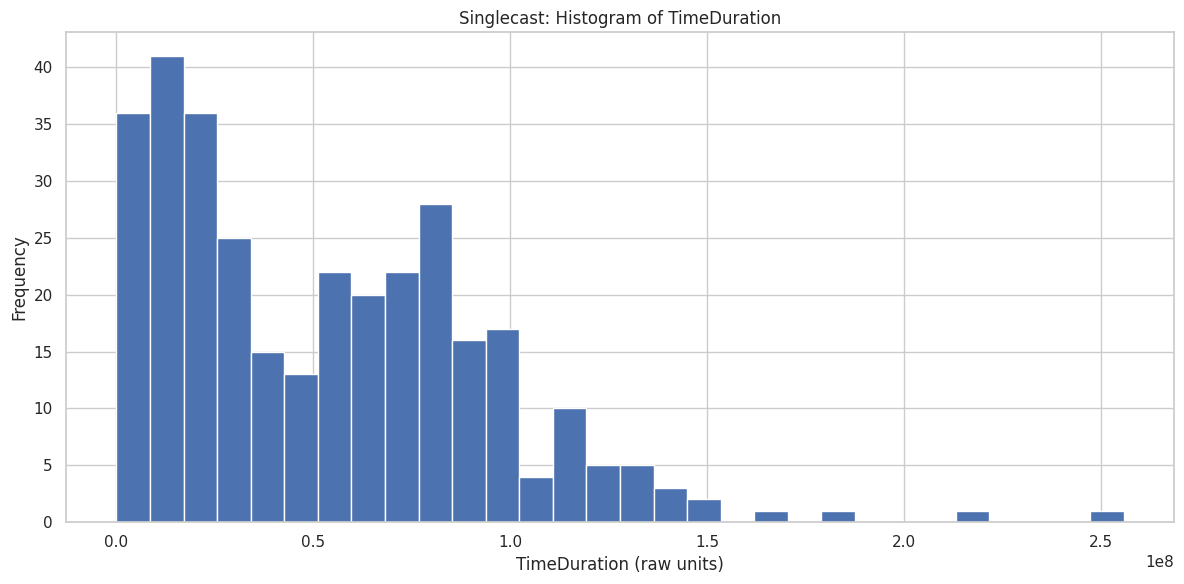

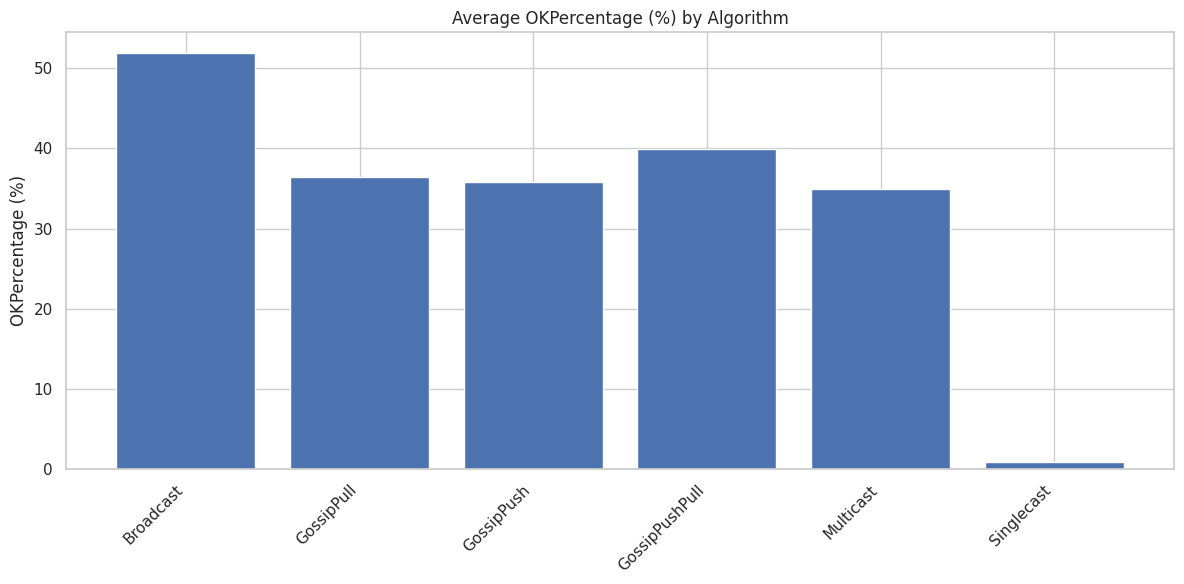

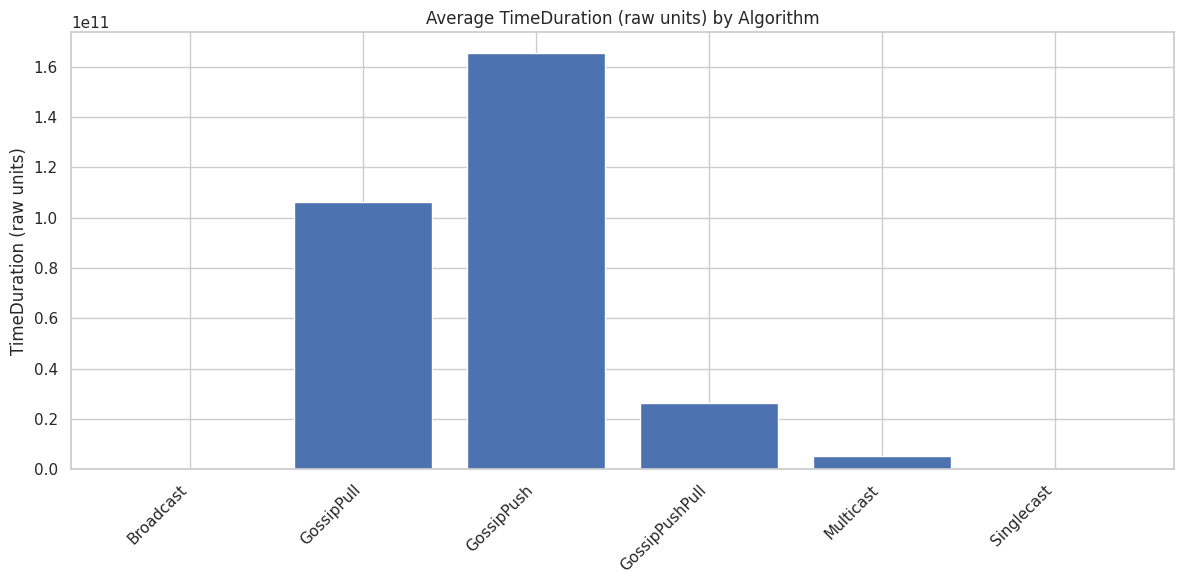

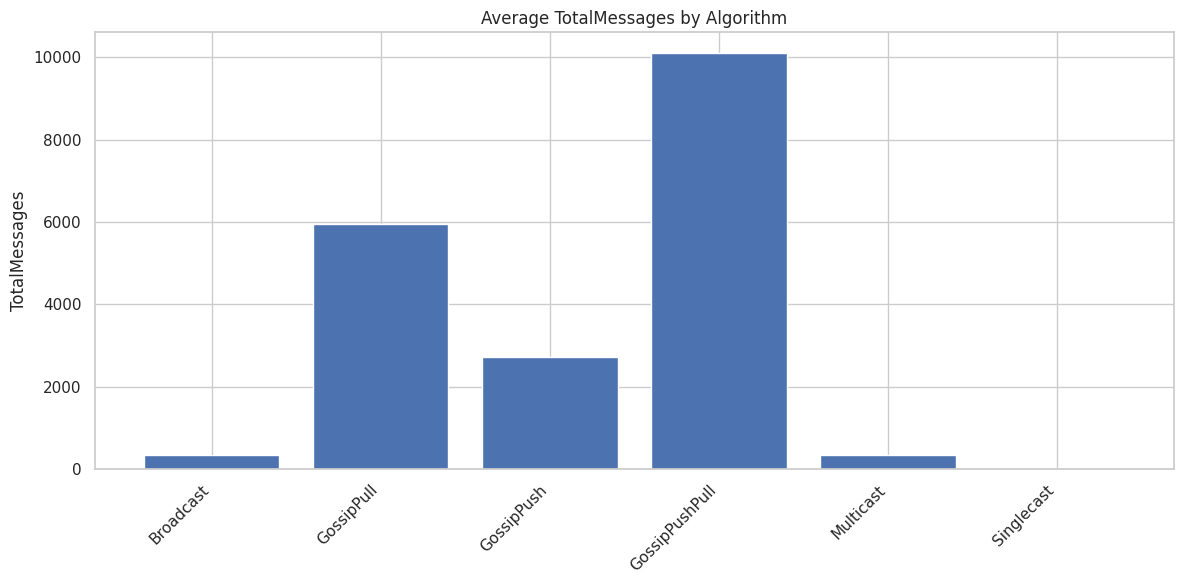

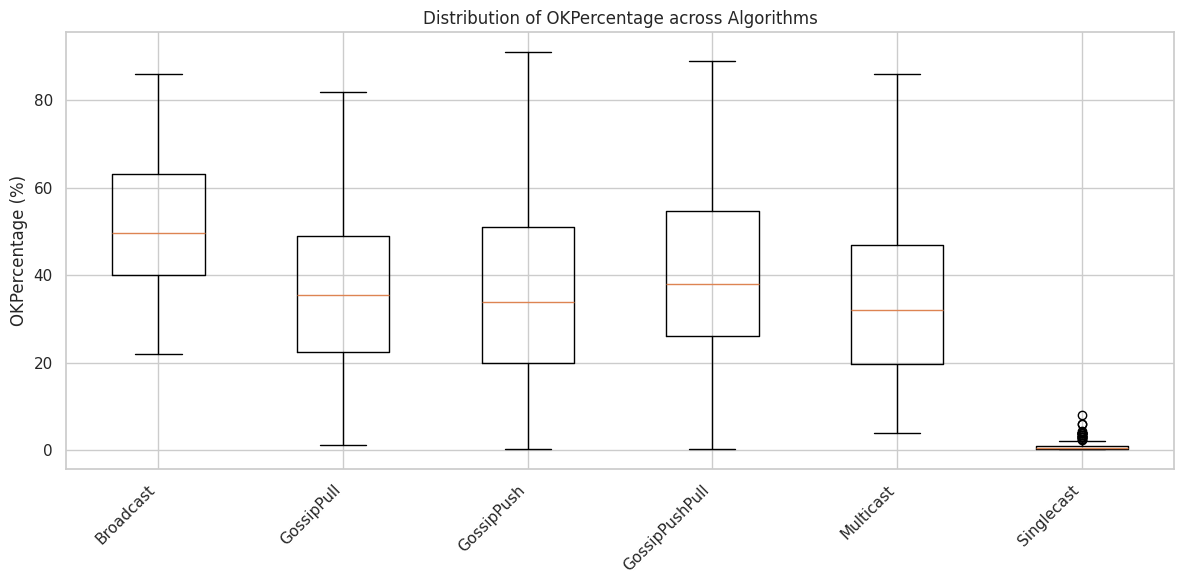

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import os

# Load the CSV that you uploaded
file_path = "merics_db_100__select_from_AnalyzeResults_ar_Full_outer_join_Experiments_e_ON__202506161355.csv"
df = pd.read_csv(file_path)

# Папка для сохранения графиков
output_dir = "histograms"
os.makedirs(output_dir, exist_ok=True)

# ---------- 1. Summary statistics table ----------
summary = (
    df.groupby("Algorithm")
      .agg(
          Mean_TimeDuration=("TimeDuration", "mean"),
          Mean_Rounds=("Rounds", "mean"),
          Mean_TotalMessages=("TotalMessages", "mean"),
          Mean_OKPercentage=("OKPercentage", "mean"),
          Mean_CorruptedPercentage=("CorruptedPercentage", "mean"),
          Mean_LostPercentage=("LostPercentage", "mean"),
      )
      .round(2)
      .reset_index()
)

# Show the interactive table to the user
display("Algorithm‑level summary", summary)

# ---------- 2. Per‑algorithm histograms ----------
metrics_per_algo = {
    "OKPercentage": {"bins": 30, "xlabel": "OK, %"},
    "TimeDuration": {"bins": 30, "xlabel": "TimeDuration (raw units)"},
}

for algo, data in df.groupby("Algorithm"):
    for metric, opts in metrics_per_algo.items():
        fig = plt.figure()
        plt.hist(data[metric].dropna(), bins=opts["bins"])
        plt.title(f"{algo}: Histogram of {metric}")
        plt.xlabel(opts["xlabel"])
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

        # Название файла
        filename = f"{algo.lower()}_{metric.lower()}_histogram.png".replace(" ", "_")
        filepath = os.path.join(output_dir, filename)

        # Сохраняем
        fig.savefig(filepath, dpi=300)
        plt.close(fig)
        print()

# ---------- 3. Comparison charts across algorithms ----------

# Helper to make a simple bar chart
def bar_chart(metric, ylabel, filename):
    fig = plt.figure()
    means = summary[metric]
    plt.bar(summary["Algorithm"], means)
    plt.ylabel(ylabel)
    plt.title(f"Average {ylabel} by Algorithm")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    fig.savefig(os.path.join(output_dir, filename), dpi=300)
    plt.close(fig)

# Bar charts
bar_chart("Mean_OKPercentage", "OKPercentage (%)", "okpercentage_bar.png")
bar_chart("Mean_TimeDuration", "TimeDuration (raw units)", "timeduration_bar.png")
bar_chart("Mean_TotalMessages", "TotalMessages", "totalmessages_bar.png")


# Boxplot of OKPercentage for all algorithms
fig.savefig(os.path.join(output_dir, "okpercentage_boxplot.png"), dpi=300)
data_for_box = [df[df["Algorithm"] == algo]["OKPercentage"].dropna() for algo in summary["Algorithm"]]
plt.boxplot(data_for_box, labels=summary["Algorithm"])
plt.ylabel("OKPercentage (%)")
plt.title("Distribution of OKPercentage across Algorithms")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_dir, "okpercentage_boxplot.png"), dpi=300)
plt.close(fig)

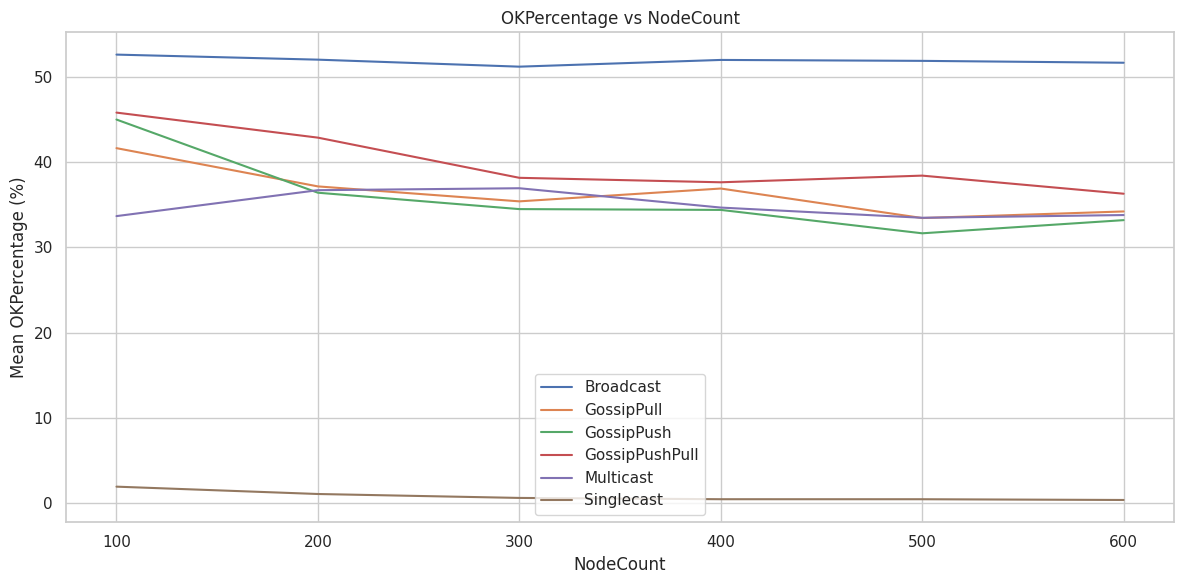

In [59]:
# Use correct column name: 'NodeCount'
df["NodeCount"] = pd.to_numeric(df["NodeCount"], errors="coerce")

# Filter out rows with missing NodeCount or Algorithm
df_filtered = df.dropna(subset=["NodeCount", "Algorithm"])

# Group by Algorithm and NodeCount and compute means for metrics of interest
grouped = (
    df_filtered
    .groupby(["Algorithm", "NodeCount"])
    .agg(
        Mean_OKPercentage=("OKPercentage", "mean"),
        Mean_TimeDuration=("TimeDuration", "mean"),
        Mean_TotalMessages=("TotalMessages", "mean"),
    )
    .reset_index()
)

# Plot OKPercentage vs NodeCount
fig = plt.figure()
for algo in grouped["Algorithm"].unique():
    subset = grouped[grouped["Algorithm"] == algo]
    plt.plot(subset["NodeCount"], subset["Mean_OKPercentage"], label=algo)
plt.title("OKPercentage vs NodeCount")
plt.xlabel("NodeCount")
plt.ylabel("Mean OKPercentage (%)")
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_dir, "OKPercentage_NodeCount.png"), dpi=300)
plt.close(fig)




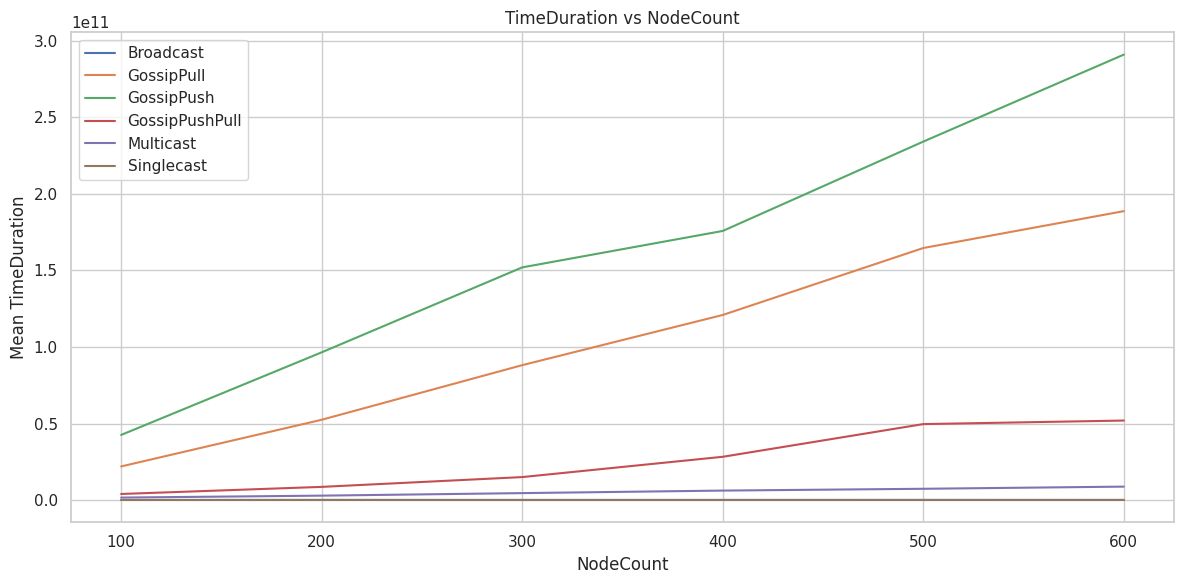

In [60]:
# Plot TimeDuration vs NodeCount
fig = plt.figure()
for algo in grouped["Algorithm"].unique():
    subset = grouped[grouped["Algorithm"] == algo]
    plt.plot(subset["NodeCount"], subset["Mean_TimeDuration"], label=algo)
plt.title("TimeDuration vs NodeCount")
plt.xlabel("NodeCount")
plt.ylabel("Mean TimeDuration")
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_dir, "TimeDuration_NodeCount.png"), dpi=300)
plt.close(fig)


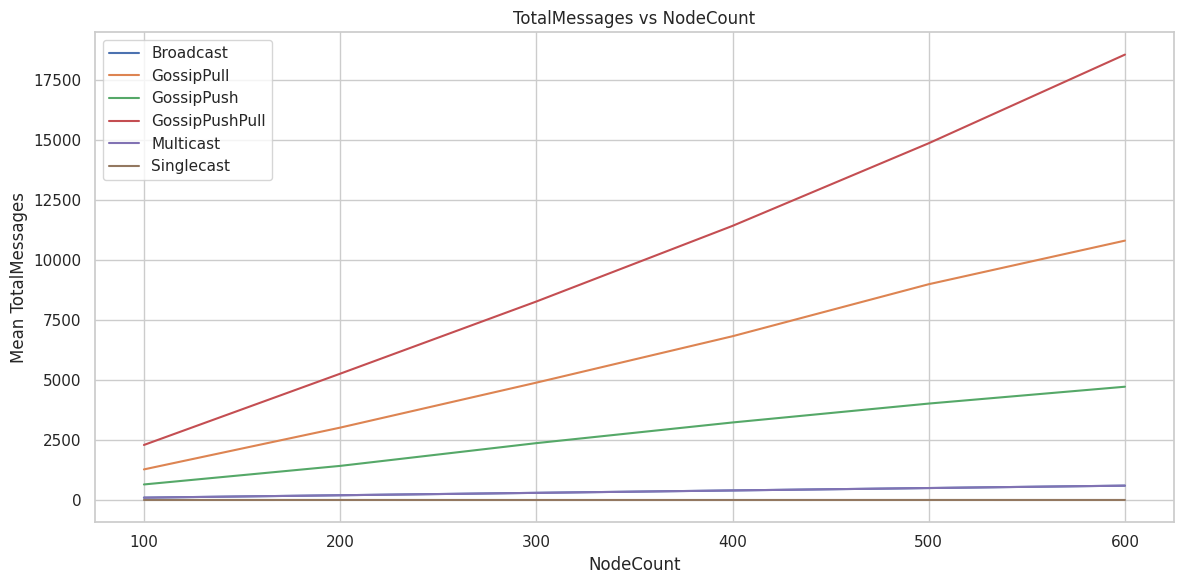

In [61]:
# Plot TotalMessages vs NodeCount
fig = plt.figure()
for algo in grouped["Algorithm"].unique():
    subset = grouped[grouped["Algorithm"] == algo]
    plt.plot(subset["NodeCount"], subset["Mean_TotalMessages"], label=algo)
plt.title("TotalMessages vs NodeCount")
plt.xlabel("NodeCount")
plt.ylabel("Mean TotalMessages")
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_dir, "TotalMessages_NodeCount.png"), dpi=300)
plt.close(fig)



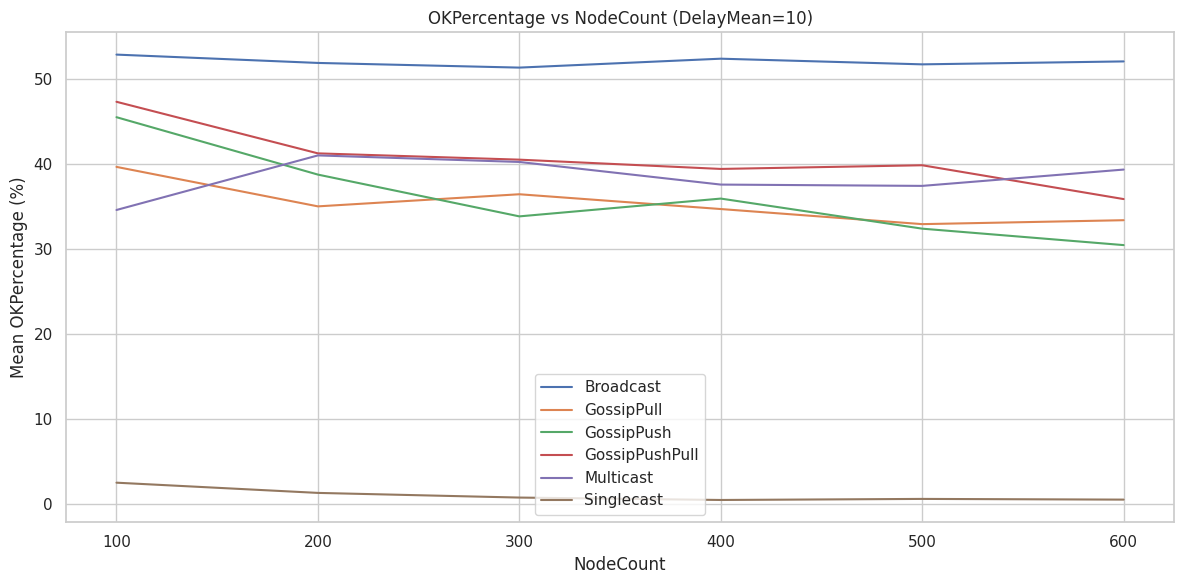

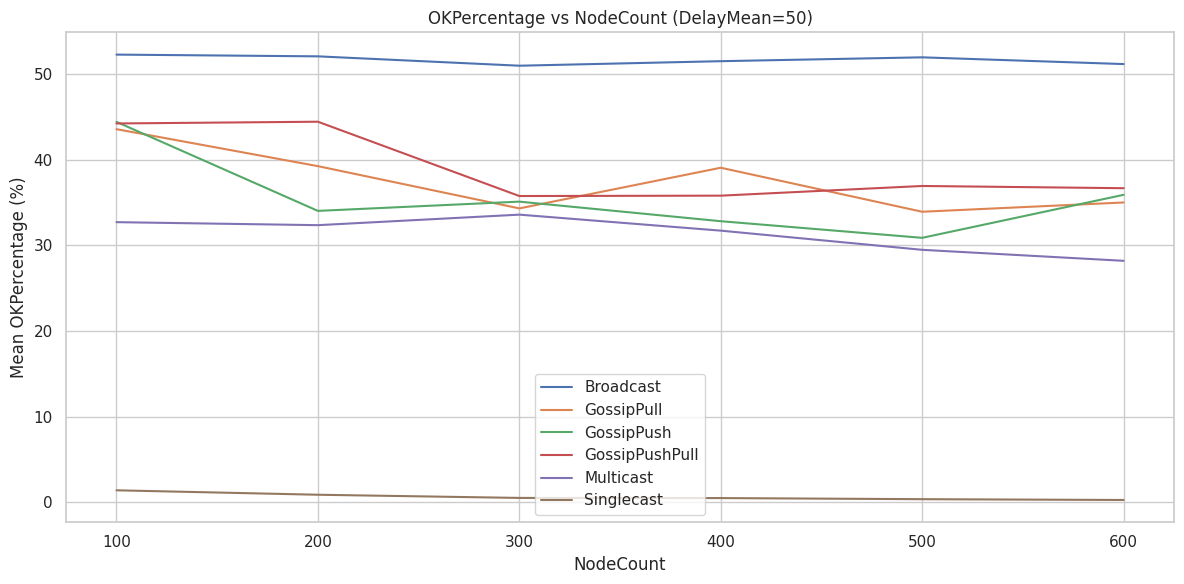

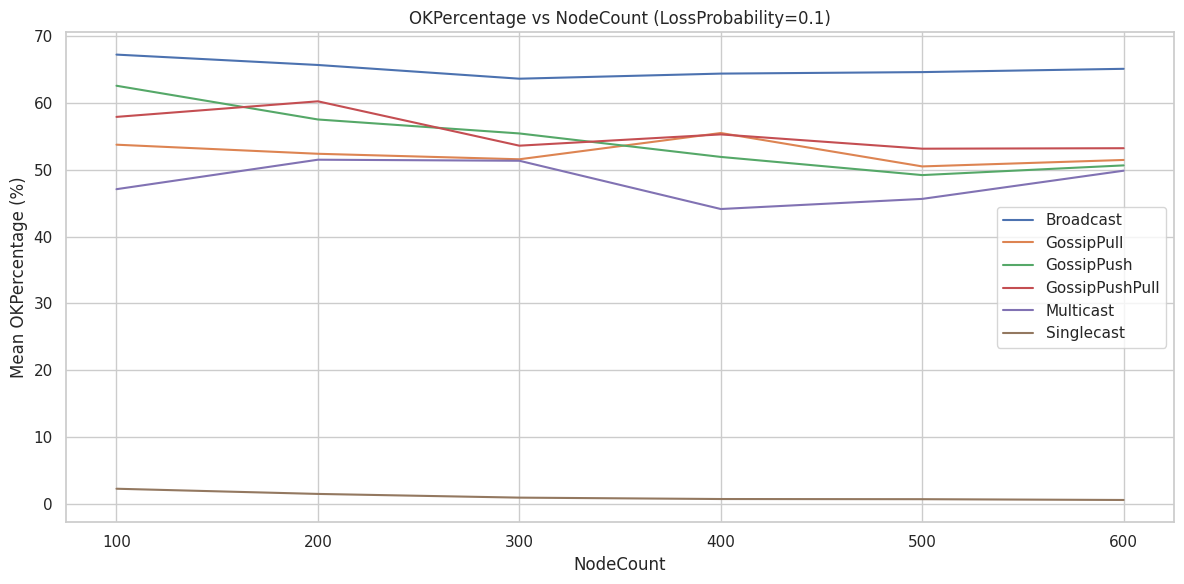

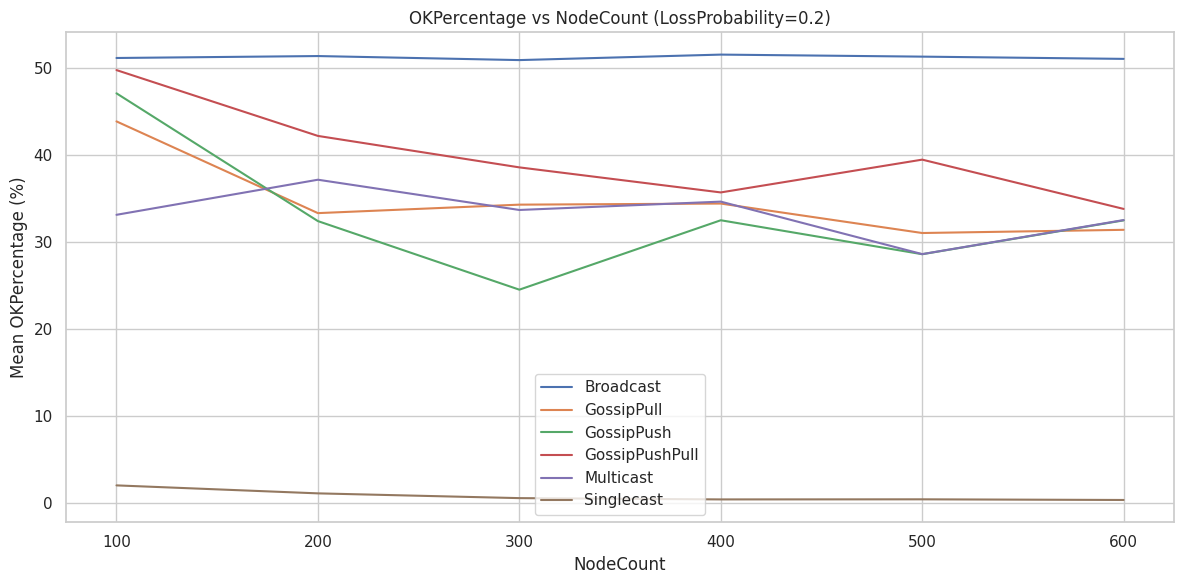

In [62]:
# Разделим графики по уровням DelayMean и LossProbability.
# Для этого сначала выясним, какие значения принимают эти параметры
unique_delay = df_filtered["DelayMean"].unique()
unique_loss = df_filtered["LossProbability"].unique()

unique_delay.sort()
unique_loss.sort()

# Для наглядности: ограничим количество значений, чтобы не перегрузить графики
selected_delays = unique_delay[:2]  # первые два значения DelayMean
selected_losses = unique_loss[:2]   # первые два значения LossProbability

# Создаем графики OKPercentage vs NodeCount по DelayMean
for delay in selected_delays:
    fig = plt.figure()
    subset_delay = df_filtered[df_filtered["DelayMean"] == delay]
    grouped_delay = (
        subset_delay.groupby(["Algorithm", "NodeCount"])
        .agg(Mean_OKPercentage=("OKPercentage", "mean"))
        .reset_index()
    )
    for algo in grouped_delay["Algorithm"].unique():
        data = grouped_delay[grouped_delay["Algorithm"] == algo]
        plt.plot(data["NodeCount"], data["Mean_OKPercentage"], label=algo)
    plt.title(f"OKPercentage vs NodeCount (DelayMean={delay})")
    plt.xlabel("NodeCount")
    plt.ylabel("Mean OKPercentage (%)")
    plt.legend()
    plt.tight_layout()
    plt.show()
    print()
    fig.savefig(os.path.join(output_dir, f"OKPercentage_NodeCount_DelayMean_{delay}.png"), dpi=300)
    plt.close(fig)

# Теперь графики OKPercentage vs NodeCount по LossProbability
for loss in selected_losses:
    fig = plt.figure()
    subset_loss = df_filtered[df_filtered["LossProbability"] == loss]
    grouped_loss = (
        subset_loss.groupby(["Algorithm", "NodeCount"])
        .agg(Mean_OKPercentage=("OKPercentage", "mean"))
        .reset_index()
    )
    for algo in grouped_loss["Algorithm"].unique():
        data = grouped_loss[grouped_loss["Algorithm"] == algo]
        plt.plot(data["NodeCount"], data["Mean_OKPercentage"], label=algo)
    plt.title(f"OKPercentage vs NodeCount (LossProbability={loss})")
    plt.xlabel("NodeCount")
    plt.ylabel("Mean OKPercentage (%)")
    plt.legend()
    plt.tight_layout()
    plt.show()
    print()
    fig.savefig(os.path.join(output_dir, f"OKPercentage_NodeCount_LossProbability_{loss}.png"), dpi=300)
    plt.close(fig)


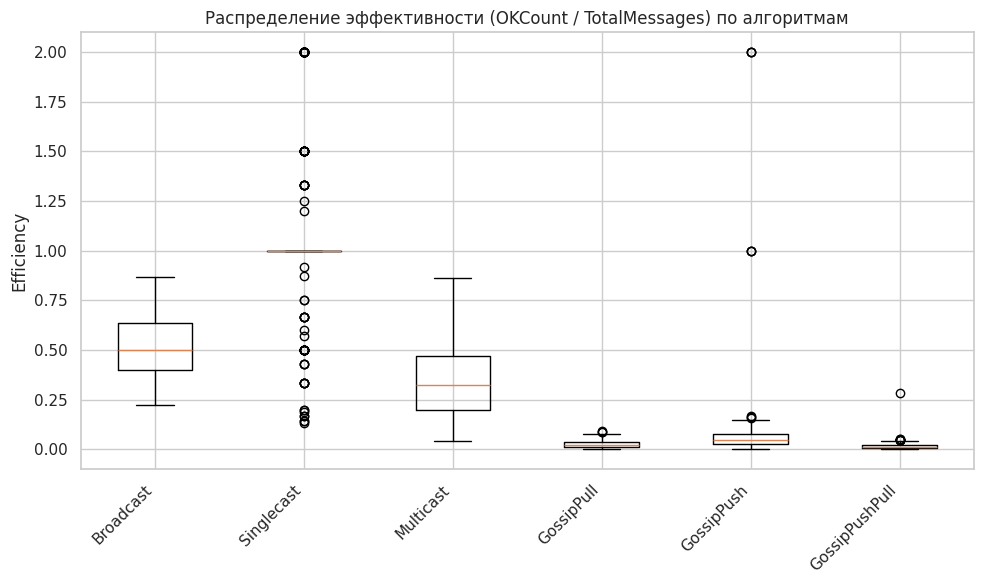

In [63]:
# Добавим метрику эффективности: OKCount / TotalMessages
df_filtered["Efficiency"] = df_filtered["OKCount"] / df_filtered["TotalMessages"]

# Группируем по алгоритму и количеству узлов
efficiency_grouped = (
    df_filtered.groupby(["Algorithm", "NodeCount"])
    .agg(Mean_Efficiency=("Efficiency", "mean"))
    .reset_index()
)

# Строим график эффективности от NodeCount
# plt.figure()
# for algo in efficiency_grouped["Algorithm"].unique():
#     subset = efficiency_grouped[efficiency_grouped["Algorithm"] == algo]
#     plt.plot(subset["NodeCount"], subset["Mean_Efficiency"], label=algo)
# plt.title("Efficiency (OKCount / TotalMessages) vs NodeCount")
# plt.xlabel("NodeCount")
# plt.ylabel("Mean Efficiency")
# plt.legend()
# plt.tight_layout()
# plt.show()

# Построим boxplot для эффективности по каждому алгоритму
fig = plt.figure(figsize=(10, 6))

# Готовим данные
eff_data = [df_filtered[df_filtered["Algorithm"] == algo]["Efficiency"].dropna()
            for algo in df_filtered["Algorithm"].unique()]
labels = df_filtered["Algorithm"].unique()

# Строим boxplot
plt.boxplot(eff_data, labels=labels)
plt.title("Распределение эффективности (OKCount / TotalMessages) по алгоритмам")
plt.ylabel("Efficiency")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_dir, "efficiency_boxplot.png"), dpi=300)
plt.close(fig)


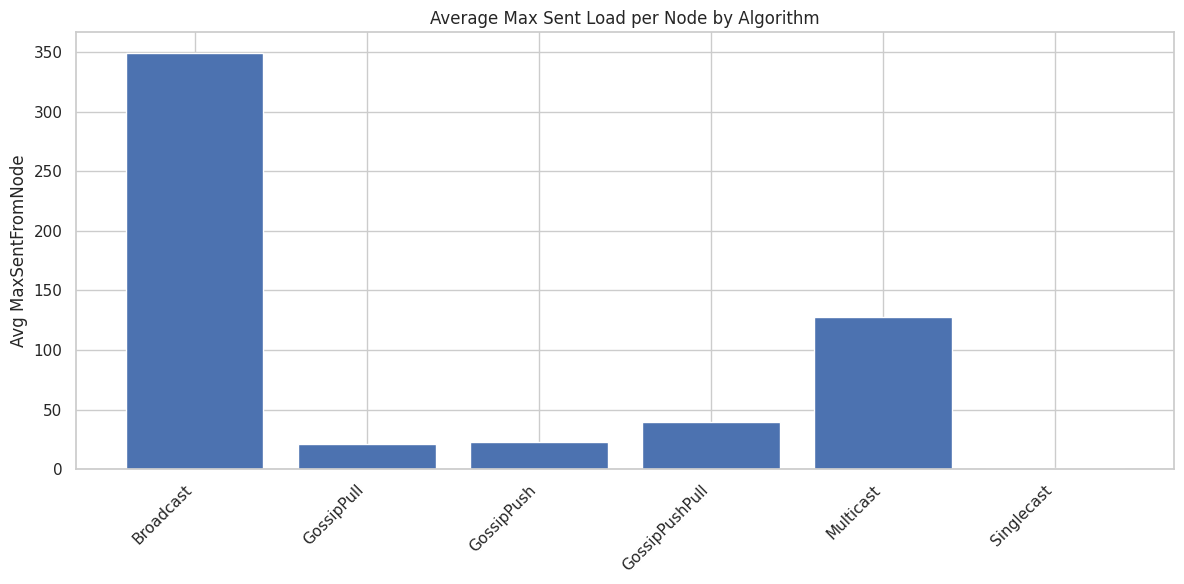

In [64]:


# Группируем по алгоритму и рассчитываем среднюю нагрузку
node_load = (
    df.groupby("Algorithm")
    .agg(
        Avg_MaxSent=("MaxSentFromNode", "mean"),
        Avg_MaxReceived=("MaxReceivedByNode", "mean")
    )
    .reset_index()
)

# Построим столбчатую диаграмму для MaxSentFromNode
fig = plt.figure()
plt.bar(node_load["Algorithm"], node_load["Avg_MaxSent"])
plt.title("Average Max Sent Load per Node by Algorithm")
plt.ylabel("Avg MaxSentFromNode")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_dir, "maxsent_bar.png"), dpi=300)
plt.close(fig)

In [65]:
!zip -r /content/barplots.zip /content/histograms


updating: content/histograms/ (stored 0%)
updating: content/histograms/OKPercentage_NodeCount_DelayMean_50.png (deflated 17%)
updating: content/histograms/okpercentage_bar.png (deflated 25%)
updating: content/histograms/efficiency_boxplot.png (deflated 21%)
updating: content/histograms/broadcast_timeduration_histogram.png (deflated 37%)
updating: content/histograms/timeduration_bar.png (deflated 24%)
updating: content/histograms/totalmessages_bar.png (deflated 26%)
updating: content/histograms/gossippull_timeduration_histogram.png (deflated 35%)
updating: content/histograms/okpercentage_boxplot.png (deflated 36%)
updating: content/histograms/OKPercentage_NodeCount.png (deflated 18%)
updating: content/histograms/gossippushpull_okpercentage_histogram.png (deflated 39%)
updating: content/histograms/OKPercentage_NodeCount_LossProbability_0.1.png (deflated 18%)
updating: content/histograms/broadcast_okpercentage_histogram.png (deflated 38%)
updating: content/histograms/TimeDuration_NodeCoun

In [66]:
!rm -rf /content/histograms